In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Distance
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

#find stellar distance for LMC stars based on Van Der Marel 2001 (eq 8)
def dist2LMC(ra, dec):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(82.25) #ra of LMC center
    delt0 = np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(25.86) #inclination #27.81
    pa = np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

# Modified version of the above to test 
def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

# [ra,dec,pa,inc]
# best params: [82.36271032823551, -69.73662459779977, 148.78306172598795, 25.856372265418806] 
# deviation: [0.20404435 0.20410712 0.28573288 0.1779363 ]

#get distance from map
def distfrommap(dismap,RA,DEC,proj):
    mu0 = 5*np.log10(49.9e3) - 5
    cpt = proj.all_world2pix(RA,DEC,1)
    x = int(np.round(cpt[0]))
    y = int(np.round(cpt[1]))
    if np.isfinite(dismap[x][y])==True:
        distance = (10**(0.2*(dismap[x][y]+mu0+5)))/1000
    else:
        distmod = (dismap[x][y+1]+dismap[x][y-1]+dismap[x+1][y]+dismap[x-1][y])*0.25
        distance = (10**(0.2*(distmod+mu0+5)))/1000
    return distance

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
#########################
### Import fits files ###
#########################

filepath1 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers.dr16beta.fits'
filepath2 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_delmu_v1_high.fits' #dist map

lmcdr16 = fits.getdata(filepath1,1)
lmcmap = fits.getdata(filepath2,0)

In [3]:
# '''This code is no longer used'''
# '''Copied from Madison Kadrmas (this is essentially the same as the dist2LMC func above)'''

# def distlmc(ra,dec):
#     angdist = []
#     angpos = []
#     dist = []
#     racenter=81.9*np.pi/180
#     deccenter= -69.866667*np.pi/180
#     distcenter=50
#     xang=(34.7)*np.pi/180    # inclination
#     zang=(180+90)*np.pi/180   # position angle of line-of-nodes
#     angdist=np.arccos(np.cos(dec*np.pi/180)*np.cos(deccenter)*np.cos((ra*np.pi/180)-(racenter))+np.sin(dec*np.pi/180)*np.sin(deccenter))
#     angpos = np.arccos((-np.cos(dec*np.pi/180)*np.sin((ra*np.pi/180)-(racenter)))/(np.sin(angdist)))
#     dist =((distcenter)*(np.cos(xang)))/(np.cos(xang)*np.cos(angdist)-np.sin(xang)*np.sin(angdist)*np.sin(angpos-zang))
#     angdist *= (180/np.pi)
#     angpos *= (180/np.pi)    
#     #print(ra, dec, angdist, angpos, dist)
#     return angdist,angpos,dist

# rho = []
# phi = []
# distance = []

# for i in range(len(lmcdr16)):
#     rho1,phi1,dist1 = distlmc(lmcdr16['RA'][i],lmcdr16['DEC'][i])
#     rho.append(rho1)
#     phi.append(phi1)
#     distance.append(dist1)


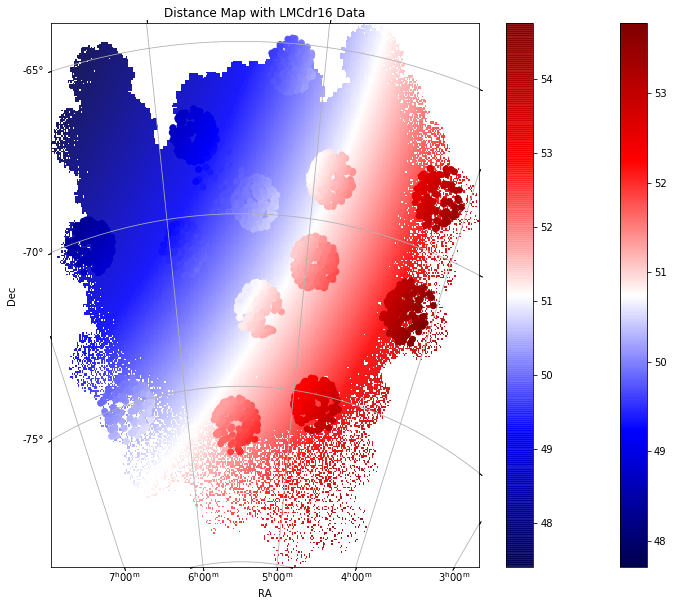

In [4]:
########################
### LMC Distance Map ###
########################

from astropy.wcs import wcs

dis = dist2LMC(lmcdr16['RA'],lmcdr16['DEC'])

hdulist = fits.open(filepath2)
hdu = fits.getdata(filepath2,0)
mu0 = 5*np.log10(49.9e3) - 5
hdudist = (10**(0.2*(hdu+mu0+5)))/1000
w = wcs.WCS(hdulist[0].header)

coor = SkyCoord(lmcdr16['RA'],lmcdr16['DEC'],frame="icrs", unit="deg")
new  = w.all_world2pix(lmcdr16['RA'],lmcdr16['DEC'],1)

fig = plt.figure(figsize=[12,10])
fig.add_subplot(111, projection=w)
plt.gca().invert_xaxis()
plt.scatter(new[0],new[1],c=dis,cmap='seismic')
plt.colorbar()
plt.imshow(hdudist,origin='lower',cmap=plt.cm.seismic,aspect='auto',alpha=0.9)
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')
#plt.imshow(np.subtract(hdu+49.9,distsamp),origin='lower',cmap=plt.cm.jet,aspect='auto',alpha=0.5)
plt.title(r'Distance Map with LMCdr16 Data')
plt.gca().invert_xaxis()
plt.grid(True)
#plt.scatter(new[0][0],new[1][0],marker='+',c='yellow')
#plt.savefig('distLMCdr16.pdf',bbox_inches='tight')
plt.show()

In [5]:
# ##################################################################
# ### Find difference between the distance map and the equations ###
# ##################################################################

# x = range(333)
# y = range(345)
# xx,yy = np.meshgrid(x,y)
# co = w.all_pix2world(xx,yy,1)
# distsamp = dist2LMCtest(co[0],co[1],82.25, -69.5, 148.30068905643682, 25.86)

# mapfin = np.where(np.isfinite(hdu)==True)
# equfin = np.where(np.isfinite(distsamp)==True)

# fig = plt.figure(figsize=[15,10])
# fig.add_subplot(111, projection=w)
# plt.imshow(np.subtract(hdudist,distsamp),origin='lower',cmap=plt.cm.jet,aspect='auto')
# plt.colorbar()
# plt.gca().invert_xaxis()
# plt.xlabel(r'RA')
# plt.ylabel(r'DEC')
# plt.title(r'Difference Between Map and Distance Equation with Color as difference $(kpc)$')
# plt.show()

In [6]:
# np.min(np.subtract(hdudist,distsamp)[np.where(np.isfinite(np.subtract(hdudist,distsamp))==True)])*1000

In [7]:
# # Modified version of the above to test 
# def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
#     ra1 = np.copy(ra)
#     dec1 = np.copy(dec)
#     ra1 = np.radians(ra1)
#     dec1 = np.radians(dec1)
#     alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
#     delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
#     sd = np.sin(delt0)
#     cd = np.cos(delt0)
#     d0 = 49.9
#     io = np.radians(io) #inclination #25.86
#     pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
#     cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
#     sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
#     sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
#     dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
#     return dis

In [8]:
# n = 10

# maxes = []
# for i in range(n):
#     alph0_rand = np.random.uniform(82.25-0.25, 82.25+0.25)
#     delt0_rand = np.random.uniform(-69.5-0.25, -69.5+0.25)
#     pa_rand = np.random.uniform(149.37-0.37, 149.37+0.37)
#     io_rand = np.random.uniform(25.86-0.25, 25.86+0.25)
    
#     x = range(333)
#     y = range(345)
#     xx,yy = np.meshgrid(x,y)
#     co = w.all_pix2world(xx,yy,1)
#     distsamptest = dist2LMCtest(co[0],co[1],alph0_rand,delt0_rand,pa_rand,io_rand)
    
#     fig = plt.figure(figsize=[15,10])
#     fig.add_subplot(111, projection=w)
#     plt.imshow(np.subtract(hdudist,distsamptest),origin='lower',cmap=plt.cm.jet,aspect='auto')
#     sub = np.subtract(hdudist,distsamptest)
#     subfin = np.where(np.isfinite(np.subtract(hdudist,distsamptest))==True)
#     plt.colorbar()
#     plt.gca().invert_xaxis()
#     plt.xlabel(r'RA')
#     plt.ylabel(r'DEC')
#     print('plot number: '+str(i+1))
#     print('ra cen: '+str(alph0_rand))
#     print('dec cen: '+str(delt0_rand))
#     print('pa: '+str(pa_rand))
#     print('io: '+str(io_rand))
#     print('max dev from map: '+str(max(sub[subfin])))
#     maxes.append(max(sub[subfin]))
#     plt.show()
    
# print(maxes)
# print('best params: '+str(1+np.argmin(maxes)))
# print('best max: '+str(maxes[np.argmin(maxes)]))

In [9]:
# n = 5000

# #convert pixel coordinates to world coordinates
# x = range(333)
# y = range(345)
# xx,yy = np.meshgrid(x,y)
# co = w.all_pix2world(xx,yy,1)

# stat = []
# params = []
# for i in range(n):
#     alph0_rand = np.random.uniform(82.25-0.25, 82.25+0.25) 
#     delt0_rand = np.random.uniform(-69.5-0.25, -69.5+0.25)
#     pa_rand = np.random.uniform(149.23-0.49, 149.23+0.49)
#     io_rand = np.random.uniform(25.86-0.19, 25.86+0.19)
    
#     params.append([alph0_rand,delt0_rand,pa_rand,io_rand])
#     distsamptest = dist2LMCtest(co[0],co[1],alph0_rand,delt0_rand,pa_rand,io_rand)
#     sub = np.subtract(hdudist,distsamptest)
#     subfin = np.where(np.isfinite(np.subtract(hdudist,distsamptest))==True)
#     stat.append(max(sub[subfin])**2)
    
# rahist = []
# dechist = []
# pahist = []
# iohist = []

# for j in range(len(params)):
#     rahist.append(params[j][0])
#     dechist.append(params[j][1])
#     pahist.append(params[j][2])
#     iohist.append(params[j][3])
    
# var = [(max(rahist)-min(rahist))/12,(max(dechist)-min(dechist))/12,(max(pahist)-min(pahist))/12,(max(iohist)-min(iohist))/12]

# #print('stat: '+str(stat[np.argmin(stat)]))
# print('best params: '+str(params[np.argmin(stat)]))
# print('deviation: '+str(np.sqrt(var)))

# distsamp = dist2LMCtest(co[0],co[1],params[np.argmin(stat)][0],params[np.argmin(stat)][1],params[np.argmin(stat)][2],params[np.argmin(stat)][3])
# plt.figure(figsize=[10,10])
# fig.add_subplot(111, projection=w)
# plt.imshow(np.subtract(hdudist,distsamp),origin='lower',cmap=plt.cm.jet,aspect='auto')
# plt.colorbar()
# plt.title(r'Difference (kpc)')
# plt.show()


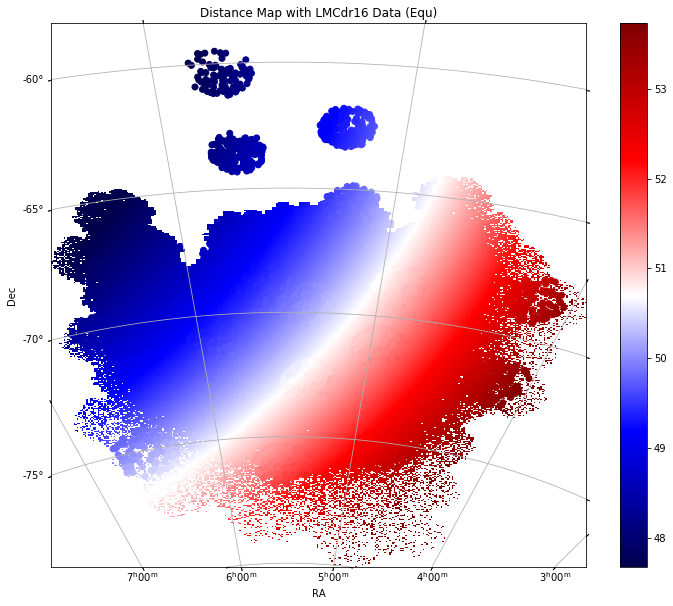

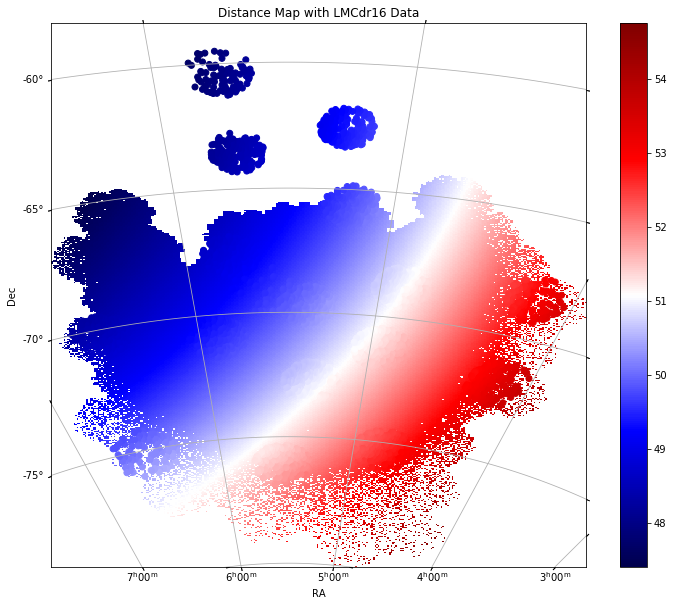

In [15]:
### Normalization testing

dis_a = dist2LMCtest(lmcdr16['RA'],lmcdr16['DEC'],82.36271032823551, -69.73662459779977, 148.78306172598795, 25.856372265418806)
hdulist = fits.open(filepath2)
hdu = fits.getdata(filepath2,0)
mu0 = 5*np.log10(49.9e3) - 5
hdudist = (10**(0.2*(hdu+mu0+5)))/1000
w = wcs.WCS(hdulist[0].header)

fin = np.where(np.isfinite(hdu)==True)

coor = SkyCoord(lmcdr16['RA'],lmcdr16['DEC'],frame="icrs", unit="deg")
new  = w.all_world2pix(lmcdr16['RA'],lmcdr16['DEC'],1)

###Norm equ
fig = plt.figure(figsize=[12,10])
fig.add_subplot(111, projection=w)
plt.gca().invert_xaxis()

plt.imshow(hdudist,origin='lower',cmap=plt.cm.seismic,aspect='auto',alpha=1,vmax=max(dis_a),vmin=min(dis_a))
#plt.colorbar()
plt.scatter(new[0],new[1],c=dis_a,cmap='seismic') #,vmax=max(hdudist[fin]),vmin=min(hdudist[fin])
plt.colorbar()

plt.xlabel('RA')
plt.ylabel('Dec')
#plt.imshow(np.subtract(hdu+49.9,distsamp),origin='lower',cmap=plt.cm.jet,aspect='auto',alpha=0.5)
plt.title(r'Distance Map with LMCdr16 Data (Equ)')
plt.gca().invert_xaxis()
plt.grid(True)
#plt.scatter(new[0][0],new[1][0],marker='+',c='yellow')
#plt.savefig('distLMCdr16.pdf',bbox_inches='tight')
plt.show()

###Norm map
fig = plt.figure(figsize=[12,10])
fig.add_subplot(111, projection=w)
plt.gca().invert_xaxis()

plt.imshow(hdudist,origin='lower',cmap=plt.cm.seismic,aspect='auto',alpha=1)
plt.colorbar()
plt.scatter(new[0],new[1],c=dis_a,cmap='seismic',vmax=max(hdudist[fin]),vmin=min(hdudist[fin]))
#plt.colorbar()

plt.xlabel('RA')
plt.ylabel('Dec')
#plt.imshow(np.subtract(hdu+49.9,distsamp),origin='lower',cmap=plt.cm.jet,aspect='auto',alpha=0.5)
plt.title(r'Distance Map with LMCdr16 Data')
plt.gca().invert_xaxis()
plt.grid(True)

plt.savefig('distLMCdr16.pdf',bbox_inches='tight')
plt.show()

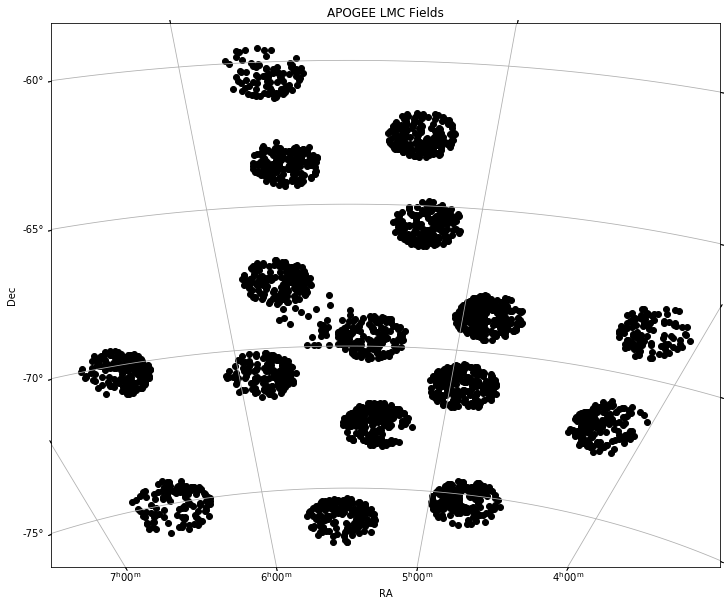

In [20]:
fig = plt.figure(figsize=[12,10])
fig.add_subplot(111, projection=w)
plt.gca().invert_xaxis()
plt.scatter(new[0],new[1],c='k',cmap='seismic')
plt.xlabel('RA')
plt.ylabel('Dec')
#plt.gca().invert_xaxis()
plt.grid(True)
plt.title(r'APOGEE LMC Fields')
plt.savefig('LMCdr16.pdf',bbox_inches='tight')
plt.show()

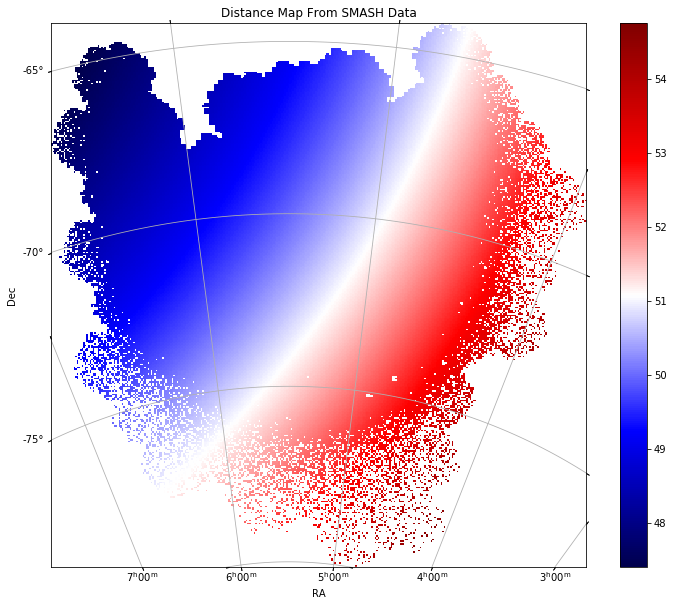

In [19]:
fig = plt.figure(figsize=[12,10])
fig.add_subplot(111, projection=w)
plt.gca().invert_xaxis()

plt.imshow(hdudist,origin='lower',cmap=plt.cm.seismic,aspect='auto',alpha=1)
plt.colorbar()
#plt.scatter(new[0],new[1],c=dis_a,cmap='seismic',vmax=max(hdudist[fin]),vmin=min(hdudist[fin]))
#plt.colorbar()

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title(r'Distance Map From SMASH Data')
plt.gca().invert_xaxis()
plt.grid(True)

plt.savefig('distLMCSMASH.pdf',bbox_inches='tight')
plt.show()

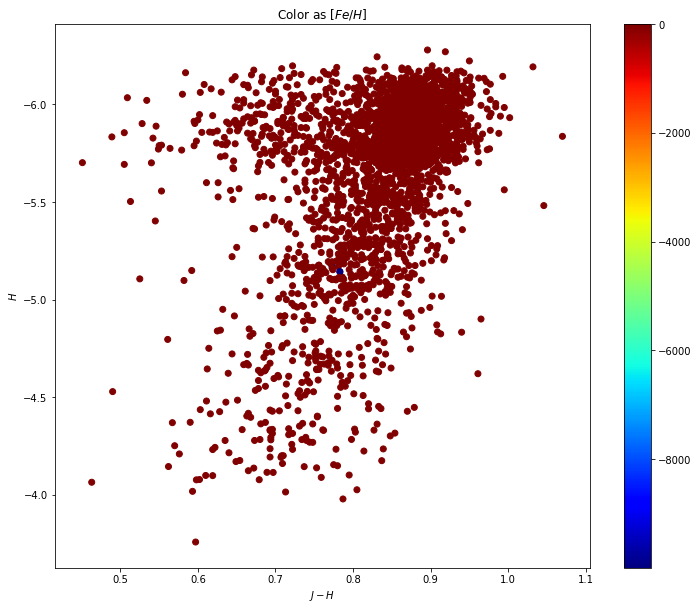

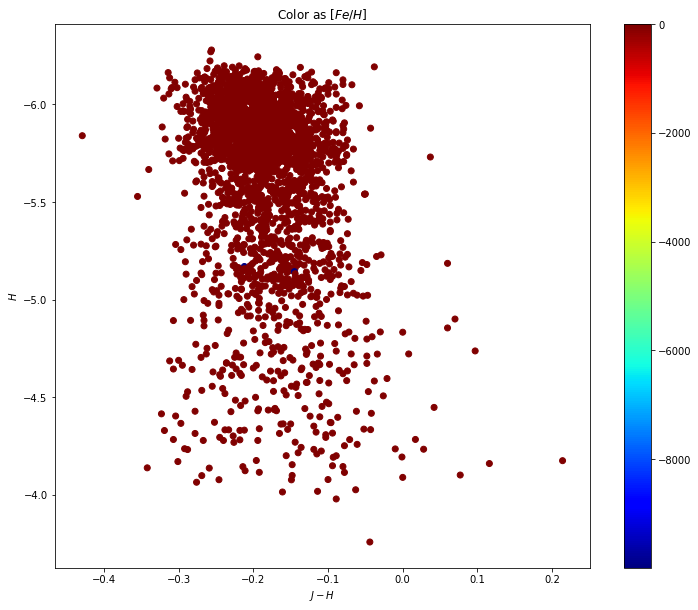

In [11]:
##########################################
#### Find Absolute Magnitude for H,J,K ###
##########################################

stardist = dist2LMCtest(lmcdr16['RA'],lmcdr16['DEC'],82.36271032823551, -69.73662459779977, 148.78306172598795, 25.856372265418806)

absH = absmag(lmcdr16['H'],stardist,False)
absJ = absmag(lmcdr16['J'],stardist,False)
absK = absmag(lmcdr16['K'],stardist,False)

### CMD with J-H, H
plt.figure(figsize=[12,10])
plt.scatter(np.subtract(absJ,absH),absH,c=lmcdr16['FE_H'],cmap='jet')
plt.colorbar()
#plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$J - H$')
plt.ylabel(r'$H$')
plt.title(r'Color as $[Fe/H]$')
plt.show()


### CMD with K-H, H
plt.figure(figsize=[12,10])
plt.scatter(np.subtract(absK,absH),absH,c=lmcdr16['FE_H'],cmap='jet')
plt.colorbar()
#plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$J - H$')
plt.ylabel(r'$H$')
plt.title(r'Color as $[Fe/H]$')
plt.show()


In [12]:
###################
### Yumi's Code ###
###################

def radec2rhophi(ra, dec): # in radian
    D0 = 49.9 # kpc 
    ra_cen = np.deg2rad(82.25)    # RA of the LMC center in rad
    dec_cen = np.deg2rad(-69.5)   # DEC the LMC center in rad
    bcen_ra= np.deg2rad(79.9083)   # RA center of the bar (de Vaucouleurs & Freeman 1972)
    bcen_dec = np.deg2rad(-69.4514) # DEC center of the bar 
    ra = np.deg2rad(ra)
    dec = np.deg2rad(dec)
    crc=np.cos(ra_cen) ; src=np.sin(ra_cen)   # cos ra_cen, sin ra_cen
    cdc=np.cos(dec_cen) ; sdc=np.sin(dec_cen) # cos dec_cen, sin dec_cen
    cr1 = np.cos(ra-ra_cen); sr1 = np.sin(ra-ra_cen)
    cd = np.cos(dec); sd = np.sin(dec)
    x = -D0 * sr1 * cd
    y =  D0 * (sd* cdc - cd* sdc* cr1 )
    crho = cd * cdc * cr1  + sd * sdc         #cos(rho)
    rho = np.arccos(crho)
    phi = np.real(- 1j* np.log((x+ 1j* y)/(D0 * np.sin(rho)))) # in rad 0. <= phi < 2* np.pi
    return rho, phi  # in radians

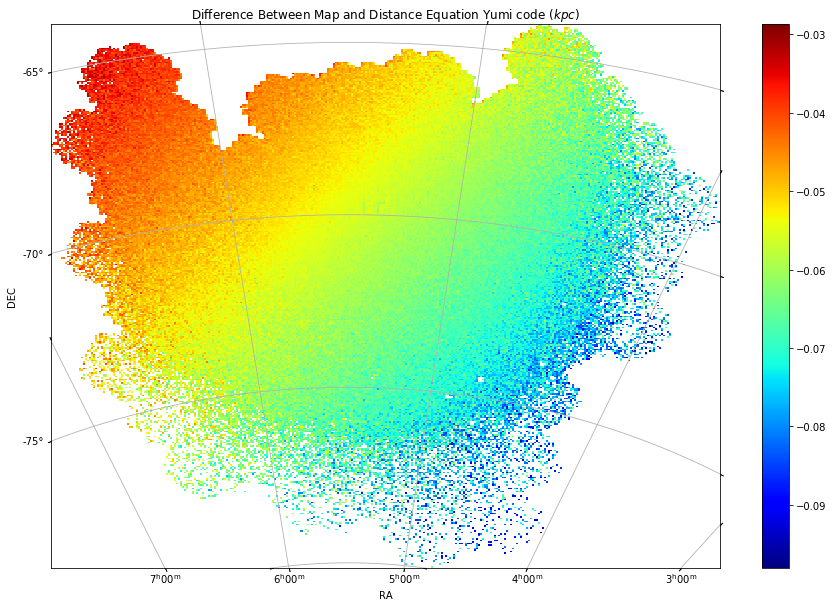

In [13]:
###############################################################
### Yumi's Code and Parameters Compared to the Distance Map ###
###############################################################

x = range(333)
y = range(345)
xx,yy = np.meshgrid(x,y)
co = w.all_pix2world(xx,yy,1)
#distsamp = dist2LMCtest(co[0],co[1],82.25, -69.5, 148.30068905643682, 25.86)

rho, phi = radec2rhophi(co[0],co[1])
add = np.where(phi<0.)
phi[add] = phi[add] + 2*np.pi
incl = np.deg2rad(25.86)
pa = np.deg2rad(149.23+90.0)
all_D = 49.9*np.cos(incl)/(np.cos(incl)*np.cos(rho) - np.sin(incl)*np.sin(rho)*np.sin(phi-pa))

# mapfin = np.where(np.isfinite(hdu)==True)
# equfin = np.where(np.isfinite(distsamp)==True)

fig = plt.figure(figsize=[15,10])
fig.add_subplot(111, projection=w)
plt.imshow(np.subtract(hdudist,all_D),origin='lower',cmap=plt.cm.jet,aspect='auto')
plt.colorbar()
plt.gca().invert_xaxis()
plt.grid(True)
plt.xlabel(r'RA')
plt.ylabel(r'DEC')
plt.title(r'Difference Between Map and Distance Equation Yumi code $(kpc)$')
plt.show()

Mine - Hers


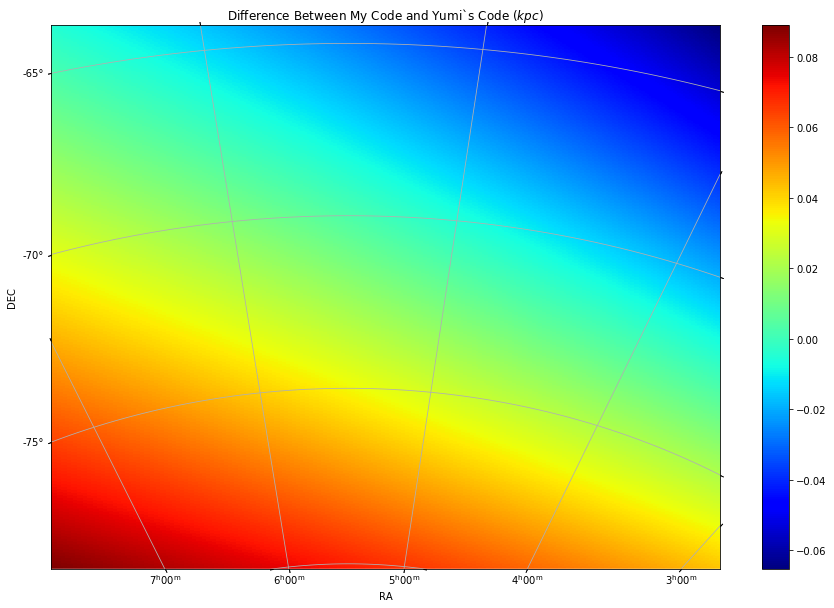

In [14]:
##############################
### My code vs Yumi's Code ###
##############################

x = range(333)
y = range(345)
xx,yy = np.meshgrid(x,y)
co = w.all_pix2world(xx,yy,1)
distsamp = dist2LMCtest(co[0],co[1],82.25, -69.5, 148.30068905643682, 25.86)

rho, phi = radec2rhophi(co[0],co[1])
add = np.where(phi<0.)
phi[add] = phi[add] + 2*np.pi
incl = np.deg2rad(25.86)
pa = np.deg2rad(149.23+90.0)
all_D = 49.9*np.cos(incl)/(np.cos(incl)*np.cos(rho) - np.sin(incl)*np.sin(rho)*np.sin(phi-pa))

fig = plt.figure(figsize=[15,10])
fig.add_subplot(111, projection=w)
plt.imshow(np.subtract(distsamp,all_D),origin='lower',cmap=plt.cm.jet,aspect='auto')
plt.colorbar()
plt.gca().invert_xaxis()
plt.grid(True)
plt.xlabel(r'RA')
plt.ylabel(r'DEC')
plt.title(r'Difference Between My Code and Yumi`s Code $(kpc)$')
print(r'Mine - Hers')
plt.show()